In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from Corrfunc.theory.DDsmu import DDsmu
from hankel import HankelTransform
from scipy.interpolate import InterpolatedUnivariateSpline as spline 
path ='/Users/ngoc/Desktop/Master-study/project'

In [2]:
#cosmological parameters
z        = 0.306                   #redshift
f        = 0.687255861             #growth rate
Omg_lamb = 0.685                   #dark energy density parameter
Omg_m    = 1. - Omg_lamb           #matter density parameter
a        = 1./(1. + z)             #scale factor
E_a      = np.sqrt(Omg_m*(1.+z)**3. + Omg_lamb) 


In [3]:
#simulation parameters
boxsize  = 2000                    #length of the box [Mpc/h]
nthreads = 4                       #number of Open MP threads to use 
autocorr = 1                       #auto correlation
nbins    = 50                      #number of bins
rmin     = 1.                      #minimum separation [Mpc/h]
rmax     = boxsize/3               #maximum separation [Mpc/h]
bins     = np.logspace(np.log10(rmin), np.log10(rmax), nbins+1)     
mu_max   = 1                       #maximum value of cosine of the angle separated from the LOS
nmu_bins = 10                      #number of bins of the angle separation 
delta_mu = mu_max/nmu_bins
set_data = "112345678"             #for reading data



In [4]:
#Legendre polynomials
P0 = 1
P2 = lambda mu: (3*mu**2-1)/2
P4 = lambda mu: (35*mu**4 - 30*mu**2 + 3)/8 


In [5]:
i = 0
# load positions of objects
X = np.loadtxt(path+'/catalogs/'+set_data[0]+set_data[i+1]+'/gals/2gpc/R1'+set_data[0]+set_data[i+1]+'_S014_clu_d.cat', usecols = (1))
Y = np.loadtxt(path+'/catalogs/'+set_data[0]+set_data[i+1]+'/gals/2gpc/R1'+set_data[0]+set_data[i+1]+'_S014_clu_d.cat', usecols = (2))
Z = np.loadtxt(path+'/catalogs/'+set_data[0]+set_data[i+1]+'/gals/2gpc/R1'+set_data[0]+set_data[i+1]+'_S014_clu_d.cat', usecols = (3))

# load velocities of objects
V_z     = np.loadtxt(path+'/catalogs/'+set_data[0]+set_data[i+1]+'/gals/2gpc/R1'+set_data[0]+set_data[i+1]+'_S014_clu_d.cat', usecols = (6))
weights = V_z/(a*E_a*100)
    
#calculate random-random pairs 
N    = len(X)          # number of halos
RR   = 4./3.*np.pi*(bins[1::]**3 - bins[0:-1:]**3)*N*(N-1)/boxsize**3
    
# using DDsmu to calculate pair in each mu bin
results_DDsmu = DDsmu(autocorr, 
                      nthreads,
                      bins,
                      mu_max,
                      nmu_bins,
                      X, Y, Z,
                      weights1    = weights,
                      boxsize     = boxsize,
                      weight_type = 'pair_product',
                      output_savg = True,
                      periodic    = True)
  
npair         = results_DDsmu['npairs']
weight        = results_DDsmu['weightavg']
mu            = results_DDsmu['mu_max']
r_mu          = results_DDsmu['savg']
DD_r_mu       = npair*weight

In [6]:

#monopole
DD_r = np.zeros(nbins)          
xi0 = np.zeros(nbins)
r0  = np.zeros(nbins)
l   = 0 
for ii in range(0,nbins):
    for j in range ((ii)*nmu_bins,(ii+1)*nmu_bins):
        xi0[ii] = xi0[ii] + DD_r_mu[j]/(RR[ii]/nmu_bins)*P0*delta_mu    
        r0[ii]  = r0[ii]  + r_mu[j]  
        DD_r[ii]= DD_r[ii]+ DD_r_mu[j]    
xi0 = (2*l+1)*xi0
r0  = r0/nmu_bins
    
#quadrupole
            
xi2 = np.zeros(nbins)
l   = 2
    
for ii in range(0,nbins):
    for j in range ((ii)*nmu_bins,(ii+1)*nmu_bins):
        xi2[ii] = xi2[ii] + DD_r_mu[j]/(RR[ii]/nmu_bins)*delta_mu*P2(mu[j])
        
xi2 = (2*l+1)*xi2


<ipython-input-7-b75deca4db96>:10: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(-100,500)


(0.03440542648052893, 500)

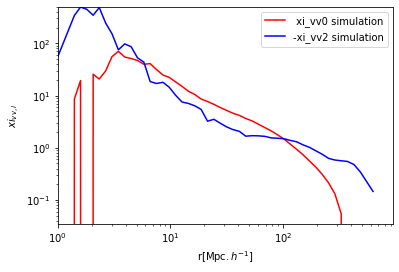

In [7]:
ax = plt.axes()
ax.set_xscale("log")
ax.set_yscale("log")
ax.plot(r0,  xi0, 'r-' , label=' xi_vv0 simulation')
ax.plot(r0, -xi2, 'b-' , label='-xi_vv2 simulation')
ax.set_ylabel("$xi_{vv,l}$")
ax.set_xlabel("r[Mpc$.h^{-1}$]")
ax.legend()
ax.set_xlim(1,)
ax.set_ylim(-100,500)





In [8]:
# The theory calculations
H_0      = 67.3                    # Hubble constant
L        = 2000                    # boxsize [Mpc.h^{-1}]
r_max    = L*3.**(1./2.)       
k_min    = 2.*np.pi/r_max
b        = 3.11                    # bias factor = delta_(galaxy or cluster)/delta_matter

In [9]:
# loading matter power spectrum

k   = np.loadtxt(path+'/results/power_spectrum.txt', usecols = (0))
P   = np.loadtxt(path+'/results/power_spectrum.txt', usecols = (1))

P_k = spline(k, P)


In [10]:
# xi_vv monopole

h0    = HankelTransform(nu=1/2, N = 2000, h = 1e-3)

f1    = lambda kk: P_k(kk)/(kk*np.pi*2)**(3/2)

xi_p1 = 1/np.sqrt(r0)*h0.transform(f1,r0, ret_err=False, inverse=True)   
    
xi_vv0_theory = f**2*xi_p1/3#*b**2  


In [11]:
# xi_vv quadrupole

h2    = HankelTransform(nu=5/2, N = 2000, h = 1e-3)

f1    = lambda kk: P_k(kk)/(kk*np.pi*2)**(3/2)

xi_p2 = 1/np.sqrt(r0)*h2.transform(f1,r0, ret_err=False, inverse=True)

xi_vv2_theory = -2/3*f**2*xi_p2#*b**2

<ipython-input-12-45b6c19f85c1>:13: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(-1,120)


(0.02997814189827389, 120)

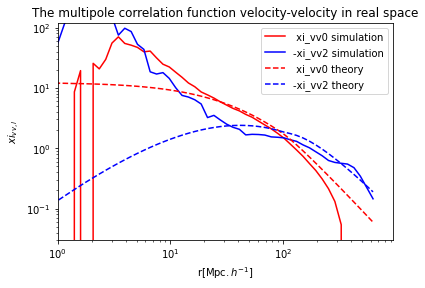

In [12]:
ax = plt.axes()
ax.set_xscale("log")
ax.set_yscale("log")
ax.plot(r0,  xi0, 'r-' , label=' xi_vv0 simulation')
ax.plot(r0, -xi2, 'b-' , label='-xi_vv2 simulation')
ax.plot(r0,  xi_vv0_theory, 'r--', label =' xi_vv0 theory')
ax.plot(r0, -xi_vv2_theory, 'b--', label ='-xi_vv2 theory')
ax.set_ylabel("$xi_{vv,l}$")
ax.set_xlabel("r[Mpc$.h^{-1}$]")
ax.set_title('The multipole correlation function velocity-velocity in real space')
ax.legend()
ax.set_xlim(1,)
ax.set_ylim(-1,120)


<ipython-input-18-d455d10e5d32>:4: RuntimeWarning: invalid value encountered in sqrt
  ax.errorbar(r0, -xi2, fmt = 'c-', yerr = (1+xi2)/np.sqrt(DD_r)*8, label ='$-\\xi_{vv,2}$ simulation Poisson error')
<ipython-input-18-d455d10e5d32>:11: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0,2.5)


(0.029488429054029913, 2.5)

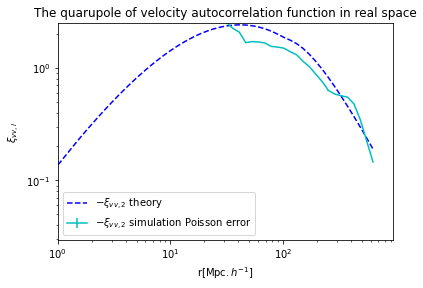

In [18]:
ax = plt.axes()
ax.set_xscale("log")
ax.set_yscale("log")
ax.errorbar(r0, -xi2, fmt = 'c-', yerr = (1+xi2)/np.sqrt(DD_r), label ='$-\\xi_{vv,2}$ simulation Poisson error')
ax.plot(r0, -xi_vv2_theory, 'b--', label ='$-\\xi_{vv,2}$ theory')
ax.set_ylabel("$\\xi_{vv,l}$")
ax.set_xlabel("r[Mpc$.h^{-1}$]")
ax.set_title('The quarupole of velocity autocorrelation function in real space')
ax.legend()
ax.set_xlim(1,)
ax.set_ylim(0,2.5)